Домашку будет легче делать в колабе (убедитесь, что у вас runtype с gpu).

# Задание 1 (3 балла)

In [185]:
import tensorflow as tf
import numpy as np
import pandas as pd
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_distances

from IPython.display import Image
from IPython.core.display import HTML 
%matplotlib inline

from razdel import tokenize as rzd_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
import gensim
from pymystem3 import Mystem

Обучите word2vec модели с негативным семплированием (cbow и skip-gram) с помощью tensorflow аналогично тому, как это было сделано в семинаре. Вам нужно изменить следующие пункты: 
1) добавьте лемматизацию в предобработку (любым способом)  
2) измените размер окна в большую или меньшую сторону
3) измените размерность итоговых векторов

Выберете несколько не похожих по смыслу слов (не таких как в семинаре), и протестируйте полученные эмбединги (найдите ближайшие слова и оцените качество, как в семинаре). 
Постарайтесь обучать модели как можно дольше и на как можно большем количестве данных. (Но если у вас мало времени или ресурсов, то допустимо взять поменьше данных и поставить меньше эпох)

In [2]:
with open('wiki_data.txt', 'r', encoding='utf-8') as fil:
    wiki = fil.read().split('\n')

In [3]:
cv = CountVectorizer(max_features=10000)
svd = TruncatedSVD(200)

X = cv.fit_transform(wiki)
X_svd = svd.fit_transform(X)
embeddings = svd.components_.T

In [4]:
id2word = cv.get_feature_names_out()
word2id = {word:i for i,word in enumerate(id2word)}

#### Добавил лемматизацию в preprocess() при помощи WordNetLemmatizer()

In [5]:
import re
lemmatizer = WordNetLemmatizer()
def preprocess(text):
    tokens = re.sub('#+', ' ', text.lower()).split()
    tokens = [token.strip(punctuation) for token in tokens]
    
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    tokens = [token for token in tokens if token]
    return tokens

In [6]:
vocab = Counter()

for text in wiki:
    vocab.update(preprocess(text))

In [7]:
len(vocab)

443187

In [8]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

In [9]:
len(filtered_vocab)

17032

In [10]:
word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

id2word = {i:word for word, i in word2id.items()}

In [11]:
sentences = []

for text in wiki:
    tokens = preprocess(text)
    if not tokens:
        continue
    ids = [word2id[token] for token in tokens if token in word2id]
    sentences.append(ids)

In [12]:
vocab_size = len(id2word)

#### В этом задании я тренировал 4 модели: 2 с негативным семплированием и 2 без него. Было интересно посмотреть на различия

## Без негативного семплирования - ради интереса

In [13]:
# skip gram
X = []
y = []

window = 10
for sent in sentences[:700]:
    for i in range(len(sent)-1):
        word = sent[i] # target
        context = sent[max(0, i-window):i] + sent[i+1:i+window]  # context (слова до и после целевого)
        # в начале и в конце окно будет неполным, но это не страшно

        for context_word in context:
            X.append(word)
            y.append(context_word)

In [14]:
X[1],y[1]

(6562, 3491)

In [15]:
len(X),len(y)

(2277856, 2277856)

In [16]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)

In [17]:
model_sg = tf.keras.Sequential()
model_sg.add(tf.keras.layers.Embedding(input_dim=len(word2id), input_length=1, output_dim=70))
model_sg.add(tf.keras.layers.Flatten())
model_sg.add(tf.keras.layers.Dense(len(word2id), activation='softmax'))
model_sg.compile(optimizer=tf.keras.optimizers.Adam(),loss='sparse_categorical_crossentropy')

In [18]:
print(model_sg.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1, 70)             1192310   
                                                                 
 flatten (Flatten)           (None, 70)                0         
                                                                 
 dense (Dense)               (None, 17033)             1209343   
                                                                 
Total params: 2401653 (9.16 MB)
Trainable params: 2401653 (9.16 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [19]:
model_sg.fit(X_train, y_train, validation_data=(X_valid, y_valid),batch_size=700, epochs=4)

Epoch 1/4
3092/3092 [==============================] - 628s 200ms/step - loss: 7.7260 - val_loss: 7.4667
Epoch 2/4
3092/3092 [==============================] - 592s 191ms/step - loss: 7.3714 - val_loss: 7.3112
Epoch 3/4
3092/3092 [==============================] - 768s 248ms/step - loss: 7.2128 - val_loss: 7.1860
Epoch 4/4
3092/3092 [==============================] - 863s 279ms/step - loss: 7.0676 - val_loss: 7.0852


dict_keys(['loss', 'val_loss'])


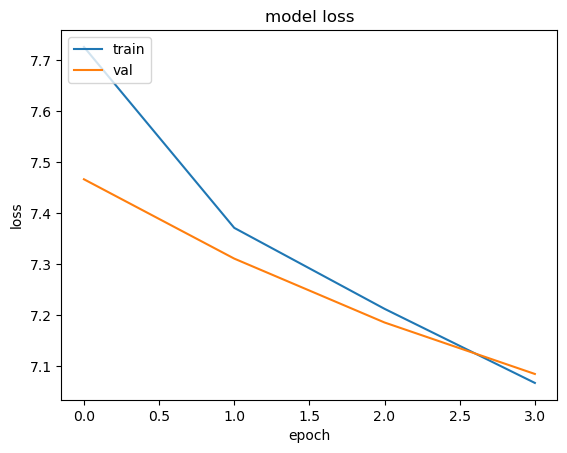

In [20]:
print(model_sg.history.history.keys())
# summarize history for accuracy
plt.plot(model_sg.history.history['loss'])
plt.plot(model_sg.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [21]:
embeddings_1_sg = model_sg.layers[0].get_weights()[0]
embeddings_2_sg = model_sg.layers[2].get_weights()[0].T

In [22]:
embeddings_sg = np.mean([embeddings_1_sg, embeddings_2_sg], axis=0)

In [23]:
def most_similar(word, embeddings):
    similar = [id2word[i] for i in 
               cosine_distances(embeddings[word2id[word]].reshape(1, -1), embeddings).argsort()[0][:10]]
    return similar

In [24]:
word2id['космос']

16566

In [25]:
most_similar('дорога', embeddings_sg)

['дорога',
 'автомобильная',
 'железная',
 'проходит',
 'пересыхающий',
 'ручей',
 'дальше',
 'пгт',
 'соединяет',
 'лесами']

In [26]:
most_similar('космос', embeddings_sg)

['космос',
 'бомбардиром',
 'аренды',
 '2005/06',
 'чемпионский',
 'мяч',
 'трофей',
 'проведённых',
 'текущего',
 '78']

In [27]:
most_similar('писатель', embeddings_sg)

['писатель',
 'поэт',
 'родился',
 'русский',
 'народный',
 'актёр',
 'почётный',
 'продюсер',
 'сценарист',
 'осло']

In [28]:
#cbow
X = []
y = []

window = 7
for sent in sentences[:5000]:
    for i in range(len(sent)-1):
        word = sent[i]
        context = sent[max(0, i-window):i] + sent[i+1:i+window]
        
        X.append(context)
        y.append(word)

In [29]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=10, padding='post')
y = np.array(y)

In [30]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)

In [31]:
model_cbow = tf.keras.Sequential()

# 1 отличие - то что на вход подается не 1 слово а целое окно контекста
# но на уровне embedding слоя нужно изменить только input_length
# она будет равна числу до которого мы делали паддинг
model_cbow.add(tf.keras.layers.Embedding(input_dim=len(word2id), input_length=10, output_dim=50))

# 2 отличие - нужно усреднить контекст в 1 вектор
model_cbow.add(tf.keras.layers.Lambda(lambda x: tf.keras.backend.sum(x, axis=1)))

model_cbow.add(tf.keras.layers.Dense(len(word2id), activation='softmax'))
model_cbow.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss='sparse_categorical_crossentropy')

In [32]:
print(model_cbow.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 10, 50)            851650    
                                                                 
 lambda (Lambda)             (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 17033)             868683    
                                                                 
Total params: 1720333 (6.56 MB)
Trainable params: 1720333 (6.56 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [33]:
model_cbow.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=1000,epochs=4)

Epoch 1/4
916/916 [==============================] - 237s 257ms/step - loss: 7.7051 - val_loss: 7.2858
Epoch 2/4
916/916 [==============================] - 217s 237ms/step - loss: 6.9986 - val_loss: 6.8377
Epoch 3/4
916/916 [==============================] - 220s 240ms/step - loss: 6.5689 - val_loss: 6.5602
Epoch 4/4
916/916 [==============================] - 221s 241ms/step - loss: 6.2583 - val_loss: 6.3919


dict_keys(['loss', 'val_loss'])


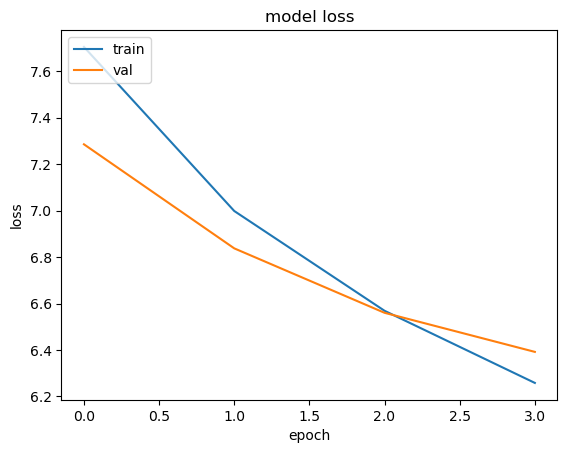

In [34]:
print(model_cbow.history.history.keys())
# summarize history for accuracy
plt.plot(model_cbow.history.history['loss'])
plt.plot(model_cbow.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [35]:
embeddings_1_cbow = model_cbow.layers[0].get_weights()[0]
embeddings_2_cbow = model_cbow.layers[2].get_weights()[0].T
embeddings_cbow = np.mean([embeddings_1_cbow, embeddings_2_cbow], axis=0)

In [36]:
most_similar('дорога', embeddings_cbow)

['дорога',
 'железная',
 'автомобильная',
 'проходит',
 'автодорога',
 'рядом',
 'проходят',
 'трасса',
 'региональная',
 'станция']

In [37]:
most_similar('космос', embeddings_cbow)

['космос',
 'эфир',
 'парный',
 'заменил',
 'ролях',
 'вышел',
 'стэнли',
 'британии',
 'третий',
 'премьер-лиге']

In [38]:
most_similar('писатель', embeddings_cbow)

['писатель',
 'педагог',
 'публицист',
 'драматург',
 'поэт',
 'учёный',
 'переводчик',
 'философ',
 'критик',
 'историк']

## С негативным семплированием

In [39]:
# skip gram
def gen_batches_sg(sentences, window = 7, batch_size=1000):
    
    left_context_length = (window/2).__ceil__()
    right_context_length = window // 2 
    
    while True:
        X_target = []
        X_context = []
        y = []

        for sent in sentences:
            for i in range(len(sent)-1):
                word = sent[i]
                context = sent[max(0, i-left_context_length):i] + sent[i+1:i+right_context_length]
                for context_word in context:
                    X_target.append(word)
                    X_context.append(context_word)
                    y.append(1)
                    
                    X_target.append(word)
                    X_context.append(np.random.randint(vocab_size))
                    y.append(0)
                    
                    if len(X_target) >= batch_size:
                        X_target = np.array(X_target)
                        X_context = np.array(X_context)
                        y = np.array(y)
                        yield ((X_target, X_context), y)
                        X_target = []
                        X_context = []
                        y = []

In [40]:
inputs_target = tf.keras.layers.Input(shape=(1,))
inputs_context = tf.keras.layers.Input(shape=(1,))


embeddings_target = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs_target, )
embeddings_context = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs_context, )

target = tf.keras.layers.Flatten()(embeddings_target)
context = tf.keras.layers.Flatten()(embeddings_context)

dot = tf.keras.layers.Dot(1)([target, context])
outputs = tf.keras.layers.Activation(activation='sigmoid')(dot)

model_sg_neg = tf.keras.Model(inputs=[inputs_target, inputs_context], 
                       outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model_sg_neg.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [41]:
model_sg_neg.fit(gen_batches_sg(sentences[:15000], window=7), validation_data=gen_batches_sg(sentences[15000:],  window=7),
          batch_size=1000,
          steps_per_epoch=5000,
          validation_steps=30,
         epochs=4)

Epoch 1/4
5000/5000 [==============================] - 317s 63ms/step - loss: 0.4935 - accuracy: 0.7677 - val_loss: 0.5098 - val_accuracy: 0.7666
Epoch 2/4
5000/5000 [==============================] - 300s 60ms/step - loss: 0.4583 - accuracy: 0.7907 - val_loss: 0.4652 - val_accuracy: 0.7894
Epoch 3/4
5000/5000 [==============================] - 296s 59ms/step - loss: 0.4472 - accuracy: 0.7971 - val_loss: 0.4283 - val_accuracy: 0.8164
Epoch 4/4
5000/5000 [==============================] - 294s 59ms/step - loss: 0.4195 - accuracy: 0.8127 - val_loss: 0.4708 - val_accuracy: 0.7845


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


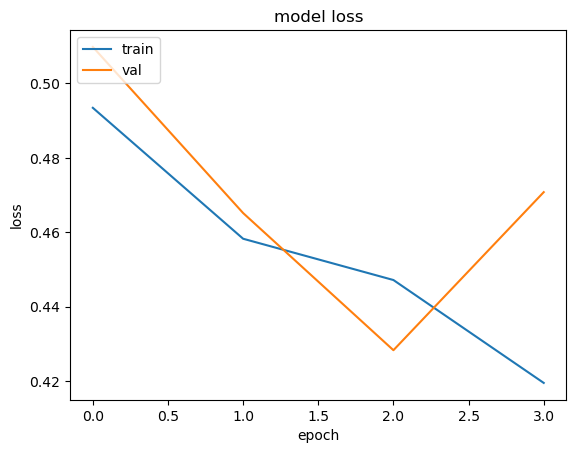

In [42]:
print(model_sg_neg.history.history.keys())
# summarize history for accuracy
plt.plot(model_sg_neg.history.history['loss'])
plt.plot(model_sg_neg.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [43]:
embeddings_sg_neg = model_sg_neg.layers[2].get_weights()[0]

In [44]:
most_similar('дорога', embeddings_sg_neg)

['дорога',
 'железная',
 'проходит',
 'рядом',
 'автомобильная',
 'станция',
 'платформа',
 'автодорога',
 'граница',
 'ближайшая']

In [45]:
most_similar('космос', embeddings_sg_neg)

['космос',
 'гонка',
 'углом',
 'картинах',
 'звездой',
 'выводы',
 'раствора',
 'кровь',
 '1762',
 'манге']

In [46]:
most_similar('писатель', embeddings_sg_neg)

['писатель',
 'композитор',
 'николай',
 'учёный',
 'андрей',
 'александр',
 'сергей',
 'педагог',
 'советский',
 'анатолий']

In [47]:
def gen_batches_cbow(sentences, window = 7, batch_size=1000):

    left_context_length = (window/2).__ceil__() 
    right_context_length = window // 2 
    
    while True:
        X_target = []
        X_context = []
        y = []

        for sent in sentences:
            for i in range(len(sent)-1):
                word = sent[i]
                context = sent[max(0, i-left_context_length):i] + sent[i+1:i+right_context_length]

                X_target.append(word)
                X_context.append(context)
                y.append(1)
                
                X_target.append(np.random.randint(vocab_size))
                X_context.append(context)
                y.append(0)

                if len(X_target) == batch_size:
                    X_target = np.array(X_target)
                    X_context = tf.keras.preprocessing.sequence.pad_sequences(X_context, maxlen=window)
                    y = np.array(y)
                    yield ((X_target, X_context), y)
                    X_target = []
                    X_context = []
                    y = []

In [48]:
inputs_target = tf.keras.layers.Input(shape=(1,))
inputs_context = tf.keras.layers.Input(shape=(10,))


embeddings_target = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs_target, )
embeddings_context = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs_context, )

target = tf.keras.layers.Flatten()(embeddings_target)
context = tf.keras.layers.Lambda(lambda x: tf.keras.backend.sum(x, axis=1))(embeddings_context)
dot = tf.keras.layers.Dot(1)([target, context])

# полученную близость нужно преобразовать в вероятность
# когда она одна используется не софтмакс и сигмоида
outputs = tf.keras.layers.Activation(activation='sigmoid')(dot)

model_cbow_neg = tf.keras.Model(inputs=[inputs_target, inputs_context], 
                       outputs=outputs)


optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model_cbow_neg.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [49]:
model_cbow_neg.fit(gen_batches_cbow(sentences[:15000], window=7),validation_data=gen_batches_cbow(sentences[15000:],  window=7),
          batch_size=1000,
          steps_per_epoch=5000,
          validation_steps=30,
         epochs=4)

Epoch 1/4
5000/5000 [==============================] - 317s 63ms/step - loss: 0.4116 - accuracy: 0.8132 - val_loss: 0.3571 - val_accuracy: 0.8461
Epoch 2/4
5000/5000 [==============================] - 305s 61ms/step - loss: 0.2991 - accuracy: 0.8720 - val_loss: 0.3244 - val_accuracy: 0.8598
Epoch 3/4
5000/5000 [==============================] - 307s 61ms/step - loss: 0.2456 - accuracy: 0.8974 - val_loss: 0.2955 - val_accuracy: 0.8815
Epoch 4/4
5000/5000 [==============================] - 305s 61ms/step - loss: 0.2154 - accuracy: 0.9115 - val_loss: 0.2618 - val_accuracy: 0.8941


In [50]:
embeddings_cbow_neg = model_cbow_neg.layers[2].get_weights()[0]

In [51]:
most_similar('дорога', embeddings_cbow_neg)

['дорога',
 'железная',
 'ветка',
 'автодорога',
 'автомобильная',
 'трасса',
 'платформа',
 'региональная',
 'переправа',
 'пересекает']

In [52]:
most_similar('космос', embeddings_cbow_neg)

['космос',
 'затвор',
 'диапазоне',
 'погоду',
 'сигнал',
 'слог',
 'пещере',
 'перерыв',
 'камере',
 'пятницу']

In [53]:
most_similar('писатель', embeddings_cbow_neg)

['писатель',
 'режиссёр',
 'педагог',
 'учёный',
 'скульптор',
 'артист',
 'поэт',
 'переводчик',
 'сценарист',
 'драматург']

# Задание 2 (3 балла)

Обучите 1 word2vec и 1 fastext модель в gensim. В каждой из модели нужно задать все параметры, которые мы разбирали на семинаре. Заданные значения должны отличаться от дефолтных и от тех, что мы использовали на семинаре.

In [54]:
with open('wiki_data.txt', 'r', encoding='utf-8') as fil:
    wiki = fil.read().split('\n')

In [55]:
texts = [preprocess(text) for text in wiki]

In [56]:
%%time
w2v = gensim.models.Word2Vec(texts, vector_size=400, min_count=5, max_vocab_size=20000, window=7, epochs=8, sg=1)

CPU times: total: 5min 12s
Wall time: 1min 47s


In [57]:
w2v.wv.most_similar('дорога')

[('железная', 0.8209481239318848),
 ('автомобильная', 0.6812784075737),
 ('железнодорожная', 0.5616933703422546),
 ('проходит', 0.5366497039794922),
 ('примыкает', 0.47799646854400635),
 ('ордовка', 0.47519057989120483),
 ('трасса', 0.4716018736362457),
 ('дороги', 0.45636552572250366),
 ('протекает', 0.4505753219127655),
 ('линия', 0.44088214635849)]

In [58]:
w2v.wv.most_similar('космос')

[('паразински', 0.5191118121147156),
 ('полёта', 0.4684179425239563),
 ('шаттла', 0.4426128566265106),
 ('палатку', 0.4371676743030548),
 ('полёт', 0.43098288774490356),
 ('борту', 0.43055108189582825),
 ('скотт', 0.42409124970436096),
 ('часа', 0.42072179913520813),
 ('бирдмора', 0.40872809290885925),
 ('отс', 0.40676039457321167)]

In [59]:
w2v.wv.most_similar('писатель')

[('поэт', 0.6139598488807678),
 ('сценарист', 0.5886619687080383),
 ('деятель', 0.5065102577209473),
 ('учёный', 0.49606919288635254),
 ('художник', 0.49394160509109497),
 ('николаевич', 0.48805946111679077),
 ('актёр', 0.4823390543460846),
 ('родился', 0.4647272825241089),
 ('русский', 0.4615662097930908),
 ('константин', 0.45700615644454956)]

In [60]:
%%time
ft = gensim.models.FastText(texts, min_n=4, max_n=7, vector_size=20, window=6, min_count=5, epochs=10)
#model2 = FastText(vector_size=20, window=6, min_count=5, epochs=10)

CPU times: total: 6min 58s
Wall time: 2min 38s


In [61]:
ft.wv.most_similar('дорога')

[('дорогая', 0.9903964996337891),
 ('дорога»', 0.9855794310569763),
 ('«дорога', 0.9760696887969971),
 ('дорогах', 0.9648817181587219),
 ('дорогобуж', 0.9609798192977905),
 ('дорогинь', 0.9563660621643066),
 ('дороги»', 0.9491344094276428),
 ('дороги', 0.942389190196991),
 ('«дороги', 0.9415652751922607),
 ('дорогу', 0.9359824061393738)]

In [62]:
ft.wv.most_similar('космос')

[('космосе', 0.9690732955932617),
 ('космоса»', 0.9579207897186279),
 ('космоса', 0.9020993113517761),
 ('«космос»', 0.8930692672729492),
 ('плакал', 0.8335369825363159),
 ('киноплёнки', 0.8206967115402222),
 ('мотоцикле', 0.8175097703933716),
 ('плакат', 0.8174269199371338),
 ('спешке', 0.813426673412323),
 ('косу', 0.8076895475387573)]

In [63]:
ft.wv.most_similar('писатель')

[('публицист', 0.9563127160072327),
 ('фольклорист', 0.9382687211036682),
 ('поэт', 0.9320330023765564),
 ('писатель-фантаст', 0.9313973188400269),
 ('литератор', 0.9189517498016357),
 ('зоолог', 0.9161456823348999),
 ('орнитолог', 0.9108163714408875),
 ('юрист', 0.9108079075813293),
 ('кельтолог', 0.9107115864753723),
 ('энтомолог', 0.9100003838539124)]

# Задание 3 (4 балла)

Используя датасет для классификации (labeled.csv) и простую нейронную сеть (последняя модель в семинаре), оцените качество полученных эмбедингов в задании 1 и 2 (4 набора эмбедингов), также проверьте 1 любую из предобученных моделей с rus-vectores (но только не tayga_upos_skipgram_300_2_2019). 
Какая модель показывает наилучший результат?

Убедитесь, что для каждой модели вы корректно воспроизводите пайплайн предобработки (в 1 задании у вас лемматизация, не забудьте ее применить к датасету для классификации; у выбранной предобученной модели может быть своя специфичная предобработка - ее нужно воспроизвести)

#### Я дополнительно тестирую cbow и skip-gram без негативного семплирования.
#### Выоды о результатах работы моделей приведениы в конце.

In [141]:
data2ch = pd.read_csv('labeled.csv')
data2ch['norm_text'] = data2ch.comment.apply(preprocess)

Лемматизация применяется в рамках функции preprocess()

In [142]:
vocab = Counter()

for text in data2ch['norm_text']:
    vocab.update(text)
    
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 5:
        filtered_vocab.add(word)

len(filtered_vocab)

7232

In [143]:
word2id = { 'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)
id2word = {i:word for word, i in word2id.items()}

In [144]:
X = []

for tokens in data2ch['norm_text']:
    ids = [word2id[token] for token in tokens if token in word2id]
    X.append(ids)

###  Word2Vec и FasText в gensim  

In [145]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=20)
y = data2ch.toxic.values

In [146]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)

In [147]:
weights = np.zeros((len(word2id), 20))

for word, i in word2id.items():
    # вектор паддинга оставим нулевым
    if word == 'PAD':
        continue

    try:
        weights[i] = ft.wv[word]
    
    
    except KeyError:
        # для слов, которых нет в модели тоже возьмем какой-то  рандомный вектор
        continue
        weights[i] = ft.wv['опрагпллирао']

In [148]:
inputs = tf.keras.layers.Input(shape=(20,))

embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=20, trainable=False, weights=[weights])(inputs, )

mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])

In [149]:
model.fit(X_train, y_train, validation_data=(X_valid, y_valid),batch_size=32,epochs=30)

Epoch 1/30
428/428 [==============================] - 4s 3ms/step - loss: 0.7761 - accuracy: 0.6066 - val_loss: 0.6777 - val_accuracy: 0.5978
Epoch 2/30
428/428 [==============================] - 1s 2ms/step - loss: 0.6439 - accuracy: 0.6401 - val_loss: 0.6211 - val_accuracy: 0.6477
Epoch 3/30
428/428 [==============================] - 1s 2ms/step - loss: 0.6021 - accuracy: 0.6742 - val_loss: 0.5960 - val_accuracy: 0.6796
Epoch 4/30
428/428 [==============================] - 1s 2ms/step - loss: 0.5838 - accuracy: 0.6918 - val_loss: 0.5835 - val_accuracy: 0.6921
Epoch 5/30
428/428 [==============================] - 1s 2ms/step - loss: 0.5741 - accuracy: 0.7022 - val_loss: 0.5763 - val_accuracy: 0.7046
Epoch 6/30
428/428 [==============================] - 1s 2ms/step - loss: 0.5685 - accuracy: 0.7045 - val_loss: 0.5728 - val_accuracy: 0.7046
Epoch 7/30
428/428 [==============================] - 1s 2ms/step - loss: 0.5651 - accuracy: 0.7073 - val_loss: 0.5702 - val_accuracy: 0.7101
Epoch 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


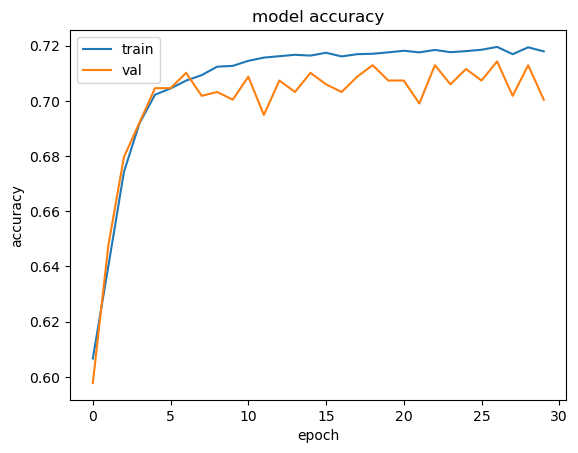

In [150]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [151]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=400)
y = data2ch.toxic.values

In [152]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)

In [153]:
weights = np.zeros((len(word2id), 400))

for word, i in word2id.items():
    # вектор паддинга оставим нулевым
    if word == 'PAD':
        continue

    try:
        weights[i] = w2v.wv[word]
    
    
    except KeyError:
        # для слов, которых нет в модели тоже возьмем какой-то  рандомный вектор
        continue
        weights[i] = w2v.wv['опрагпллирао']

In [154]:
inputs = tf.keras.layers.Input(shape=(400,))

embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=400, trainable=False, weights=[weights])(inputs, )

mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])

In [155]:
model.fit(X_train, y_train, validation_data=(X_valid, y_valid),batch_size=32,epochs=30)

Epoch 1/30
428/428 [==============================] - 7s 14ms/step - loss: 0.6594 - accuracy: 0.6632 - val_loss: 0.6361 - val_accuracy: 0.6685
Epoch 2/30
428/428 [==============================] - 8s 18ms/step - loss: 0.6294 - accuracy: 0.6650 - val_loss: 0.6220 - val_accuracy: 0.6685
Epoch 3/30
428/428 [==============================] - 50s 117ms/step - loss: 0.6217 - accuracy: 0.6650 - val_loss: 0.6171 - val_accuracy: 0.6685
Epoch 4/30
428/428 [==============================] - 9s 20ms/step - loss: 0.6179 - accuracy: 0.6650 - val_loss: 0.6137 - val_accuracy: 0.6685
Epoch 5/30
428/428 [==============================] - 9s 20ms/step - loss: 0.6147 - accuracy: 0.6650 - val_loss: 0.6106 - val_accuracy: 0.6685
Epoch 6/30
428/428 [==============================] - 9s 20ms/step - loss: 0.6116 - accuracy: 0.6650 - val_loss: 0.6076 - val_accuracy: 0.6685
Epoch 7/30
428/428 [==============================] - 10s 23ms/step - loss: 0.6087 - accuracy: 0.6650 - val_loss: 0.6048 - val_accuracy: 0.6

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


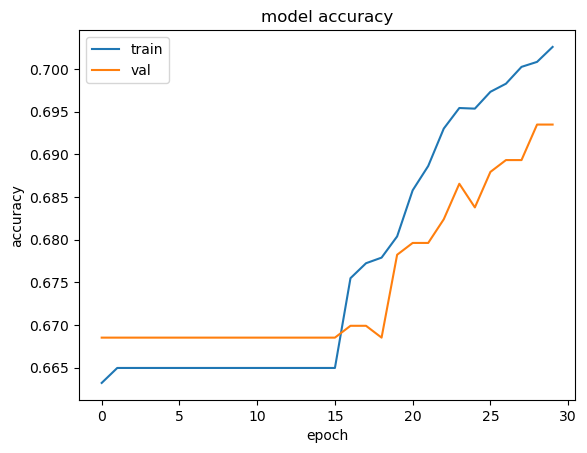

In [156]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### cbow и skip-gram без негативного семплирования

In [157]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=70)
y = data2ch.toxic.values

In [158]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)

In [159]:
weights = np.zeros((len(word2id), 70))

for word, i in word2id.items():
    # вектор паддинга оставим нулевым
    if word == 'PAD':
        continue

    try:
        weights[i] = embeddings_sg[word2id[word]].reshape(1, -1)
    
    
    except KeyError:
        # для слов, которых нет в модели тоже возьмем какой-то  рандомный вектор
        continue
        weights[i] = embeddings_sg[word2id['опрагпллирао']].reshape(1, -1)

In [160]:
inputs = tf.keras.layers.Input(shape=(70,))

embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=70, trainable=False, weights=[weights])(inputs, )

mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])

In [161]:
model.fit(X_train, y_train, validation_data=(X_valid, y_valid),batch_size=32,epochs=30)

Epoch 1/30
428/428 [==============================] - 3s 3ms/step - loss: 0.6422 - accuracy: 0.6601 - val_loss: 0.6222 - val_accuracy: 0.6602
Epoch 2/30
428/428 [==============================] - 1s 2ms/step - loss: 0.6198 - accuracy: 0.6654 - val_loss: 0.6197 - val_accuracy: 0.6602
Epoch 3/30
428/428 [==============================] - 1s 2ms/step - loss: 0.6188 - accuracy: 0.6654 - val_loss: 0.6189 - val_accuracy: 0.6602
Epoch 4/30
428/428 [==============================] - 1s 3ms/step - loss: 0.6182 - accuracy: 0.6654 - val_loss: 0.6182 - val_accuracy: 0.6602
Epoch 5/30
428/428 [==============================] - 1s 2ms/step - loss: 0.6177 - accuracy: 0.6654 - val_loss: 0.6176 - val_accuracy: 0.6602
Epoch 6/30
428/428 [==============================] - 1s 2ms/step - loss: 0.6173 - accuracy: 0.6654 - val_loss: 0.6171 - val_accuracy: 0.6602
Epoch 7/30
428/428 [==============================] - 1s 2ms/step - loss: 0.6169 - accuracy: 0.6654 - val_loss: 0.6166 - val_accuracy: 0.6602
Epoch 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


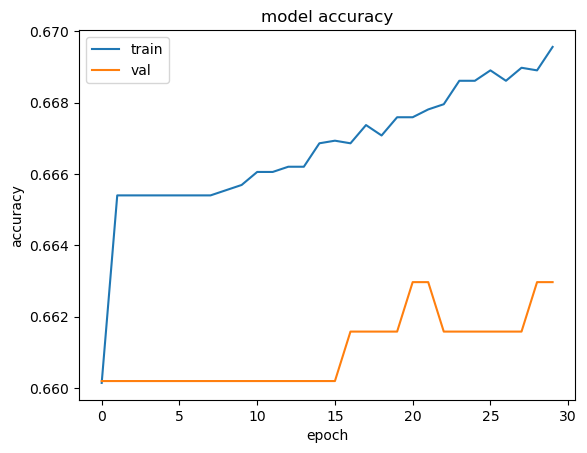

In [162]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [163]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=50)
y = data2ch.toxic.values

In [164]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)

In [165]:
weights = np.zeros((len(word2id), 50))

for word, i in word2id.items():
    # вектор паддинга оставим нулевым
    if word == 'PAD':
        continue

    try:
        weights[i] = embeddings_cbow[word2id[word]].reshape(1, -1)
        
    
    
    except KeyError:
        # для слов, которых нет в модели тоже возьмем какой-то  рандомный вектор
        continue
        weights[i] = embeddings_cbow[word2id['опрагпллирао']].reshape(1, -1)

In [166]:
inputs = tf.keras.layers.Input(shape=(50,))

embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=50, trainable=False, weights=[weights])(inputs, )

mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])

In [167]:
model.fit(X_train, y_train, validation_data=(X_valid, y_valid),batch_size=32,epochs=30)

Epoch 1/30
428/428 [==============================] - 2s 3ms/step - loss: 0.6639 - accuracy: 0.6598 - val_loss: 0.6487 - val_accuracy: 0.6546
Epoch 2/30
428/428 [==============================] - 1s 2ms/step - loss: 0.6364 - accuracy: 0.6657 - val_loss: 0.6389 - val_accuracy: 0.6546
Epoch 3/30
428/428 [==============================] - 1s 2ms/step - loss: 0.6301 - accuracy: 0.6657 - val_loss: 0.6371 - val_accuracy: 0.6546
Epoch 4/30
428/428 [==============================] - 1s 2ms/step - loss: 0.6281 - accuracy: 0.6657 - val_loss: 0.6360 - val_accuracy: 0.6546
Epoch 5/30
428/428 [==============================] - 1s 2ms/step - loss: 0.6268 - accuracy: 0.6657 - val_loss: 0.6349 - val_accuracy: 0.6546
Epoch 6/30
428/428 [==============================] - 1s 2ms/step - loss: 0.6255 - accuracy: 0.6657 - val_loss: 0.6338 - val_accuracy: 0.6546
Epoch 7/30
428/428 [==============================] - 1s 2ms/step - loss: 0.6244 - accuracy: 0.6657 - val_loss: 0.6328 - val_accuracy: 0.6546
Epoch 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


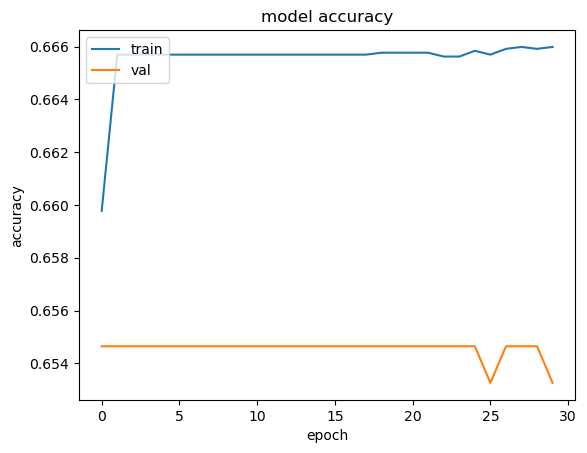

In [168]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### cbow и skip-gram с негативным семплированием

In [170]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=100)
y = data2ch.toxic.values

In [171]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)

In [172]:
weights = np.zeros((len(word2id), 100))

for word, i in word2id.items():
    # вектор паддинга оставим нулевым
    if word == 'PAD':
        continue

    try:
        weights[i] = embeddings_sg_neg[word2id[word]].reshape(1, -1)
        
    
    
    except KeyError:
        # для слов, которых нет в модели тоже возьмем какой-то  рандомный вектор
        continue
        weights[i] = embeddings_sg_neg[word2id['опрагпллирао']].reshape(1, -1)

In [173]:
inputs = tf.keras.layers.Input(shape=(100,))

embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100, trainable=False, weights=[weights])(inputs, )

mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])

In [174]:
model.fit(X_train, y_train, validation_data=(X_valid, y_valid),batch_size=32,epochs=30)

Epoch 1/30
428/428 [==============================] - 2s 3ms/step - loss: 0.6554 - accuracy: 0.6650 - val_loss: 0.6301 - val_accuracy: 0.6685
Epoch 2/30
428/428 [==============================] - 1s 2ms/step - loss: 0.6264 - accuracy: 0.6650 - val_loss: 0.6186 - val_accuracy: 0.6685
Epoch 3/30
428/428 [==============================] - 1s 2ms/step - loss: 0.6205 - accuracy: 0.6650 - val_loss: 0.6149 - val_accuracy: 0.6685
Epoch 4/30
428/428 [==============================] - 1s 3ms/step - loss: 0.6180 - accuracy: 0.6650 - val_loss: 0.6124 - val_accuracy: 0.6685
Epoch 5/30
428/428 [==============================] - 1s 3ms/step - loss: 0.6159 - accuracy: 0.6650 - val_loss: 0.6104 - val_accuracy: 0.6685
Epoch 6/30
428/428 [==============================] - 1s 3ms/step - loss: 0.6141 - accuracy: 0.6650 - val_loss: 0.6086 - val_accuracy: 0.6685
Epoch 7/30
428/428 [==============================] - 1s 3ms/step - loss: 0.6126 - accuracy: 0.6650 - val_loss: 0.6070 - val_accuracy: 0.6685
Epoch 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


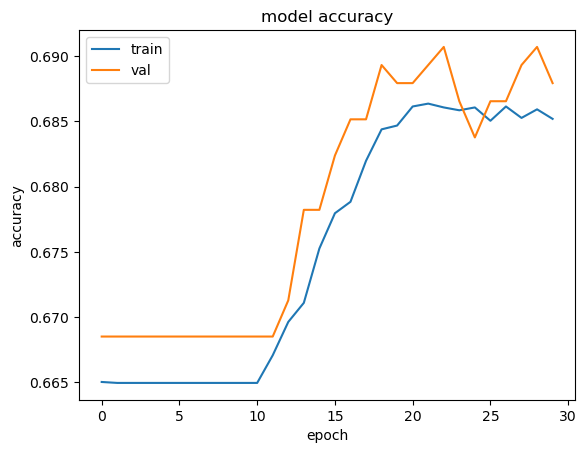

In [175]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [176]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=100)
y = data2ch.toxic.values

In [177]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)

In [178]:
weights = np.zeros((len(word2id), 100))

for word, i in word2id.items():
    # вектор паддинга оставим нулевым
    if word == 'PAD':
        continue

    try:
        weights[i] = embeddings_cbow_neg[word2id[word]].reshape(1, -1)
        
    
    
    except KeyError:
        # для слов, которых нет в модели тоже возьмем какой-то  рандомный вектор
        continue
        weights[i] = embeddings_cbow_neg[word2id['опрагпллирао']].reshape(1, -1)

In [179]:
inputs = tf.keras.layers.Input(shape=(100,))

embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100, trainable=False, weights=[weights])(inputs, )

mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])

In [180]:
model.fit(X_train, y_train, validation_data=(X_valid, y_valid),batch_size=32,epochs=30)

Epoch 1/30
428/428 [==============================] - 2s 3ms/step - loss: 0.6423 - accuracy: 0.6623 - val_loss: 0.6190 - val_accuracy: 0.6546
Epoch 2/30
428/428 [==============================] - 1s 2ms/step - loss: 0.6142 - accuracy: 0.6657 - val_loss: 0.6127 - val_accuracy: 0.6546
Epoch 3/30
428/428 [==============================] - 1s 3ms/step - loss: 0.6108 - accuracy: 0.6657 - val_loss: 0.6096 - val_accuracy: 0.6546
Epoch 4/30
428/428 [==============================] - 1s 3ms/step - loss: 0.6087 - accuracy: 0.6657 - val_loss: 0.6069 - val_accuracy: 0.6546
Epoch 5/30
428/428 [==============================] - 1s 3ms/step - loss: 0.6071 - accuracy: 0.6657 - val_loss: 0.6046 - val_accuracy: 0.6546
Epoch 6/30
428/428 [==============================] - 1s 2ms/step - loss: 0.6058 - accuracy: 0.6675 - val_loss: 0.6027 - val_accuracy: 0.6574
Epoch 7/30
428/428 [==============================] - 1s 3ms/step - loss: 0.6048 - accuracy: 0.6704 - val_loss: 0.6012 - val_accuracy: 0.6657
Epoch 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


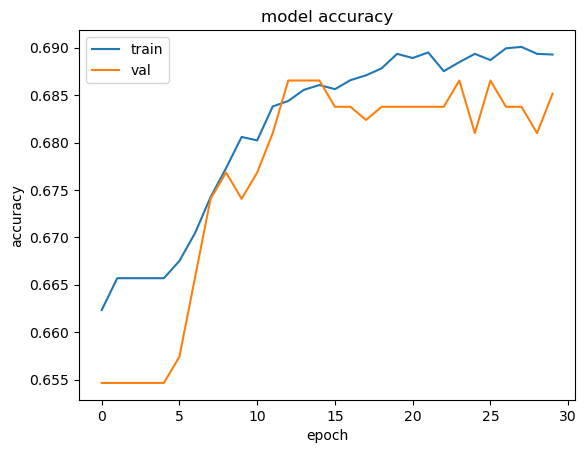

In [181]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [133]:
embeddings_cbow_neg[word2id['космос']].reshape(1, -1)

array([[-1.06316790e-01,  2.47496322e-01,  3.61021131e-01,
         1.86687157e-01,  1.07773006e-01, -3.63048390e-02,
        -3.62422436e-01, -3.46613377e-02,  1.37382090e-01,
         5.37553579e-02,  6.64869547e-02, -3.22837651e-01,
         2.73882598e-01, -2.19024606e-02,  3.34946632e-01,
         1.47599503e-01,  4.04169038e-02,  1.26817793e-01,
        -4.98096868e-02, -1.19040906e-01,  4.83489245e-01,
        -3.35976690e-01,  1.43907711e-01, -1.46075413e-01,
         1.60498425e-01,  5.72796278e-02, -6.83793128e-02,
         1.97224304e-01, -2.99659133e-01,  7.43672699e-02,
        -1.63370982e-01,  2.61928998e-02,  1.00903539e-02,
         2.78272033e-01,  9.75549966e-02,  2.41950065e-01,
         1.34568051e-01, -3.74167343e-04,  6.61381632e-02,
         1.18077490e-02, -3.39185745e-01,  2.47767448e-01,
         2.02103674e-01,  1.49785364e-02, -5.87549321e-02,
         2.33457536e-01,  6.71359003e-02,  2.03017429e-01,
        -3.53042483e-01, -6.90456703e-02, -5.47370408e-0

In [216]:

model = gensim.models.KeyedVectors.load_word2vec_format('news_upos_skipgram_300_5_2019.vec', binary=False)

In [217]:
m = Mystem()

In [218]:
mapping = {}

for line in open('./ru-rnc.map'):
    ms, ud = line.strip('\n').split()
    mapping[ms] = ud

In [219]:
def normalize_mystem(text):
    tokens = []
    norm_words = m.analyze(text)
    for norm_word in norm_words:
        if 'analysis' not in norm_word:
            continue
            
        if not len(norm_word['analysis']):
            lemma = norm_word['text']
            pos = 'UNKN'
        else:
            lemma = norm_word["analysis"][0]["lex"].lower().strip()
            pos = norm_word["analysis"][0]["gr"].split(',')[0]
            pos = pos.split('=')[0].strip()
        pos = mapping[pos]
        tokens.append(lemma+'_'+pos)

    return tokens

In [ ]:
data2ch2 = pd.read_csv('labeled.csv')
data2ch2['norm_text'] = data2ch2.comment.apply(normalize_mystem)

In [220]:
vocab_upos = Counter()

for text in data2ch['norm_text']:
    vocab.update(str(normalize_mystem(str(text))))
    
filtered_vocab_upos = set()

for word in vocab_upos:
    if vocab_upos[word] > 5:
        filtered_vocab_upos.add(word)

len(filtered_vocab_upos)

KeyboardInterrupt: 

## Выводы
#### Результаты работы моделей я оцениваю по метрикам accuracy и loss и по таким характеристикам, как время обучения и общее удобство использования. 

#### 1) Наилучшие результаты показали первые тесты с gensim-моделями, особенно FastText - он дал самые лучшие показатели accuracy и loss, был крайне удобен и интуитивен в обращении, а время на его обучение не превышало 5 минут. Это модель, которую я скорее всего взял бы на вооружение в реальной практической деятельности.

#### 2) Также неплохие показатели по метрикам дали cbow и skip-gram с негативным семплированием. Единственное, что смущает - это долгое время обучения. 5 минут на одну эпоху - это, пожалуй, слишком много. Особенно при том, что существует FastText, который может за это же время пройти 8 эпох. К тому же, эти модели немного сложнее в обращении - конструкции вроде embeddings_sg_neg[word2id[word]].reshape(1, -1) смущают. Тем не менее, если по какой-то причине мы не можем использовать gensim, можно обратиться к ним.

#### 3) То же самон нельзя сказать о cbow и skip-gram без негативного семплирования. Они обучаются очень медленно, а метрики по ним довольно некачественные. Не стоит затраченного врмени. 

#### 4) При имеющихся данных и задаче классификации токсичных текстов rusvectores *отвратителен*. В плане удобства использования это самый худший вариант из всех представленных: нерабочие ссылки на модели при полной неорганизованности сайта, а также неочевидная организация самых файлов внутри моделей делают работу с ним крайне сложной. А наличие тегов рядом с каждым токеном усложняет эту работу ещё сильнее. Мне не нужно знать, к какой части речи относится каждое из 7 основных матерных слов в русском языке, чтобы понять, что их появление, скорее всего, говорит о токсичности высказывания. Но работа с этими моделями подразумевает, что эти тэги должны либо как-то добавляться в имеющийся корпус, либо удаляться из самих моделей. Оба этих варианта крайне затратны по времени. А с учётом того, что rusvectores-модели, судя по всему, не обновляются, тратить это время бессмысленно. Мир и токсичность в нём растёт и развивается быстрее, чем мы можем себе представить, опираться на неудобные модели пятилетней давности при подобной работе - это слишком больно. 